<a href="https://colab.research.google.com/github/Wesly19-max/BIDA-A-Web-Based-Breast-Tumor-Image-Detection-Application-using-Convolutional-Neural-Networks/blob/main/ENB2_BIDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




In [20]:
# Constants
IMG_SIZE = (224, 224)  # Resize images to 224x224
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001
DECAY_RATE = 0.95

In [21]:
# Path to your pre-determined train and test directories
train_dir = '/content/drive/MyDrive/BreaKHis_Dataset/train'  # Modify with your train dataset directory
test_dir = '/content/drive/MyDrive/BreaKHis_Dataset/test'    # Modify with your test dataset directory

In [22]:
import tensorflow as tf
import cv2
import numpy as np

# Custom function to apply CLAHE, Gaussian Blur, and Sharpening
def custom_preprocessing(image):
    image = np.array(image * 255, dtype=np.uint8)  # Convert back to 0-255 range

    # Convert to grayscale for CLAHE, then back to color
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Apply Gaussian Blur
    image = cv2.GaussianBlur(image, (3, 3), 0)

    # Apply Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    return image / 255.0  # Normalize back to 0-1 range

# Wrap the function for TensorFlow's pipeline
def preprocess_function(image):
    return tf.numpy_function(custom_preprocessing, [image], tf.float32)

# Updated ImageDataGenerator with preprocessing function
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_function  # Apply custom preprocessing
)


In [23]:
# Load pre-determined datasets (train and test data)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',  # Binary classification
    shuffle=True
)

Found 1148 files belonging to 2 classes.


In [24]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',  # Binary classification
    shuffle=False  # Set shuffle=False for test data to maintain the order
)


Found 545 files belonging to 2 classes.


In [25]:
# Prefetch datasets to optimize training speed
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [26]:
# Load MobileNetV3 Large pre-trained model
base_model = EfficientNetB2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [27]:
# Freeze initial layers and fine-tune later layers
for layer in base_model.layers[:200]:
    layer.trainable = False
for layer in base_model.layers[150:]:
    layer.trainable = True

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Define IMG_SHAPE here, or ensure it's defined globally
IMG_SHAPE = (224, 224, 3)  # Example shape, adjust if necessary

def create_model():
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = base_model(inputs, training=True)  # Enable training for base model

    # Global pooling for better feature extraction
    x = GlobalAveragePooling2D()(x)

    # First fully connected layer with Swish activation
    x = Dense(256, use_bias=False, kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Activation("swish")(x)

    x = Dropout(0.2)(x)

    # Second fully connected layer
    x = Dense(128, activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Third fully connected layer
    x = Dense(64, activation='swish', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)

    # Output layer
    x = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005))(x)

    model = Model(inputs, x)

    # Compile with improved optimizer & loss function
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

    return model

model = create_model()

In [29]:
# Compile model with learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,
    decay_rate=DECAY_RATE,
    staircase=True
)

optimizer = SGD(learning_rate=lr_schedule, momentum=0.95, nesterov=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Handle class imbalance by using class weights
# Assuming class imbalance is likely, we'll calculate class weights
class_weights = {0: 1.5, 1: 1.}


In [31]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [32]:
# Train model


history = model.fit(
    train_dataset,  # Use the test dataset for validation
    validation_data=test_dataset,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weights  # Apply class weights during training
)


Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 404s 10s/step - accuracy: 0.5313 - loss: 1.3385 - val_accuracy: 0.3413 - val_loss: 1.0803
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 353s 9s/step - accuracy: 0.6214 - loss: 1.1854 - val_accuracy: 0.3853 - val_loss: 1.0760
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 390s 10s/step - accuracy: 0.7142 - loss: 1.0061 - val_accuracy: 0.4752 - val_loss: 1.0413
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 372s 9s/step - accuracy: 0.7268 - loss: 0.9285 - val_accuracy: 0.5872 - val_loss: 0.9885
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 338s 9s/step - accuracy: 0.7772 - loss: 0.8658 - val_accuracy: 0.6844 - val_loss: 0.9235
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 384s 9s/step - accuracy: 0.8215 - loss: 0.8007 - val_accuracy: 0.7670 - val_loss: 0.8638
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 312s 9s/step - accuracy: 0.8552 - loss: 0.7471 - val_accuracy: 0.8018 - val_loss: 0.8156
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 346s 10s/step - accuracy: 0.8409 - loss: 0.7556 - val_accuracy: 0.8239 

In [33]:
# Plot training and validation accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    plot_accuracy(history)

In [34]:
# Evaluate model performance on test data
y_pred_raw = model.predict(test_dataset)
y_pred = (y_pred_raw > 0.5).astype(int)  # Apply threshold for binary classification

# Get true labels
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())

# Convert to numpy for confusion matrix and metrics
y_true = np.array(y_true)


18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step


In [35]:
# Calculate performance metrics
def compute_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='binary')  # F1 for binary classification
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

compute_metrics(y_true, y_pred)

F1 Score: 0.8952
Precision: 0.9377
Recall: 0.8564


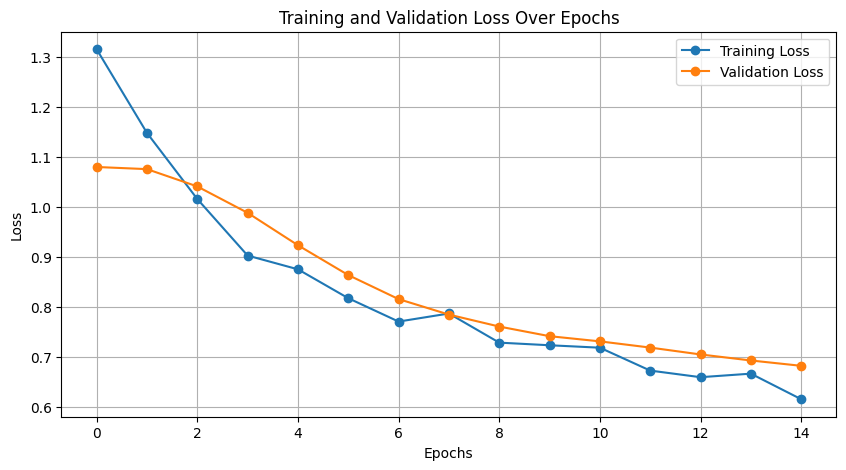

In [36]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plots the training and validation loss over epochs.
    :param history: Keras history object from model.fit()
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

# Example usage (assuming you have a history object from model.fit())
# plot_loss(history)

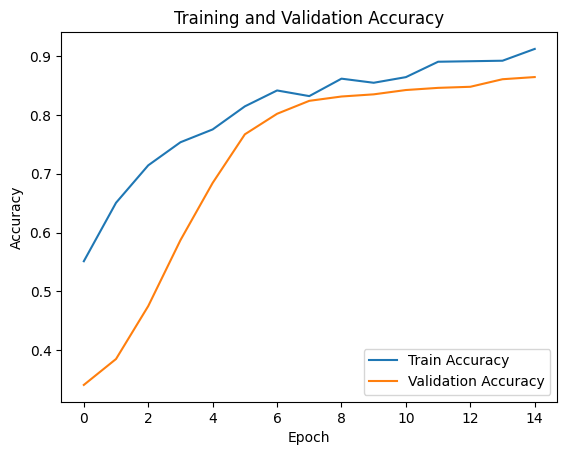

In [38]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Assuming 'history' is the variable storing the training history
plot_accuracy(history)